In [63]:
# The code was removed by Watson Studio for sharing.

# Import necesssary Libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats    
import seaborn as sns
%matplotlib inline    

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

import seaborn as sns

# Question 3 - Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

## <font color="maroon">Read Data: We will focus on 'BRONX' borough as identified borough with most 'HEAT/HOT WATER' complaints from previous questions.</font>

In [65]:
# Download data from IBM cloud
client_cred.download_file(Bucket=bucket,Key='df_raw_cos_bx.pkl',Filename='./df_raw_local.pkl')
df_bx = pd.read_pickle('./df_raw_local.pkl')
df_bx = df_bx.dropna()
df_bx.head()

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord
0,122 BRUCKNER BOULEVARD,0,0.0,0.00,5.0,6.5,1,15000,200.0,1,0.0,0,0,6.02,0,0,0,10454.0,232162.0,1005957.0
1,126 BRUCKNER BOULEVARD,752,16.0,0.05,5.0,6.5,4,13770,100.0,2,1.0,272,0,6.02,0,1931,1994,10454.0,232156.0,1006076.0
2,138 BRUCKNER BOULEVARD,39375,200.0,1.13,5.0,6.5,10,35000,200.0,1,2.0,0,0,6.02,0,1931,0,10454.0,232036.0,1006187.0
3,144 BRUCKNER BOULEVARD,12500,85.0,5.00,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,232033.0,1006299.0
4,148 BRUCKNER BOULEVARD,8595,70.0,4.58,5.0,6.5,18,1875,75.0,1,5.0,0,6876,6.02,1719,1920,2009,10454.0,232040.0,1006363.0


In [66]:
# Get the shape of the dataframe
df_bx.shape

(86591, 20)

## <font color="maroon">Read Data: NYC Complaints dataset</font>

In [67]:
# Download 311 complaints from IBM cloud
client_cred.download_file(Bucket=bucket,Key='df_raw_cos_nyc.pkl',Filename='./df_raw_local.pkl')
df_nyc = pd.read_pickle('./df_raw_local.pkl')
df_nyc.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
0,2019-12-30T13:34:17.000,45276345,HEAT/HOT WATER,10033.0,2 MAGAW PLACE,MAGAW PLACE,ADDRESS,NEW YORK,The complaint you filed is a duplicate of a co...,MANHATTAN,40.850830,-73.937283,NaN,RESIDENTIAL BUILDING,Open
1,2019-12-30T20:58:43.000,45275367,HEAT/HOT WATER,10468.0,2500 WEBB AVENUE,WEBB AVENUE,ADDRESS,BRONX,The complaint you filed is a duplicate of a co...,BRONX,40.866167,-73.904187,NaN,RESIDENTIAL BUILDING,Open
2,2019-12-30T17:18:18.000,45276885,HEAT/HOT WATER,10454.0,700 EAST 134 STREET,EAST 134 STREET,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.802459,-73.915132,NaN,RESIDENTIAL BUILDING,Open
3,2019-12-30T14:29:12.000,45277476,WATER LEAK,11221.0,700 GATES AVENUE,GATES AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.687809,-73.936668,NaN,RESIDENTIAL BUILDING,Open
4,2019-12-30T16:50:51.000,45276451,UNSANITARY CONDITION,11213.0,1018 EASTERN PARKWAY,EASTERN PARKWAY,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.668992,-73.934811,NaN,RESIDENTIAL BUILDING,Open


## Filter data to contain only complaints for BRONX before Dec 31 2018 and top complaint type 'HEAT/HOT WATER' as per question 1

In [68]:
df_complaints = df_nyc[(df_nyc.created_date <= '2018-12-31') & (df_nyc.city=='BRONX') & ((df_nyc.complaint_type=='HEAT/HOT WATER') | (df_nyc.complaint_type=='HEATING'))]
df_complaints = df_complaints.dropna()
df_complaints.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
109151,2018-12-30T11:19:41.000,41323891,HEAT/HOT WATER,10468.0,2291 DR M L KING JR BOULEVARD,DR M L KING JR BOULEVARD,ADDRESS,BRONX,The Department of Housing Preservation and Dev...,BRONX,40.860721,-73.906783,2019-01-02T02:02:57.000,RESIDENTIAL BUILDING,Closed
109155,2018-12-29T08:55:25.000,41322822,HEAT/HOT WATER,10459.0,1057 HOE AVENUE,HOE AVENUE,ADDRESS,BRONX,The Department of Housing Preservation and Dev...,BRONX,40.824309,-73.890513,2019-01-02T02:02:46.000,RESIDENTIAL BUILDING,Closed
109166,2018-12-30T14:31:50.000,41316694,HEAT/HOT WATER,10467.0,3071 PERRY AVENUE,PERRY AVENUE,ADDRESS,BRONX,The Department of Housing Preservation and Dev...,BRONX,40.872588,-73.879572,2019-01-01T09:37:20.000,RESIDENTIAL BUILDING,Closed
109171,2018-12-30T05:33:13.000,41314363,HEAT/HOT WATER,10461.0,3108 WILKINSON AVENUE,WILKINSON AVENUE,ADDRESS,BRONX,The Department of Housing Preservation and Dev...,BRONX,40.851653,-73.828635,2018-12-31T11:04:28.000,RESIDENTIAL BUILDING,Closed
109172,2018-12-30T14:46:13.000,41313337,HEAT/HOT WATER,10454.0,325 CONCORD AVENUE,CONCORD AVENUE,ADDRESS,BRONX,The Department of Housing Preservation and Dev...,BRONX,40.807012,-73.910629,2018-12-31T08:58:16.000,RESIDENTIAL BUILDING,Closed


In [69]:
# Get the shape of the dataframe
df_complaints.shape

(605941, 15)

In [70]:
# Get data types
df_complaints.dtypes

created_date               object
unique_key                  int64
complaint_type             object
incident_zip              float64
incident_address           object
street_name                object
address_type               object
city                       object
resolution_description     object
borough                    object
latitude                  float64
longitude                 float64
closed_date                object
location_type              object
status                     object
dtype: object

### Type casting for both datasets and dropping unnecessary/constant columns

In [71]:
df_bx['ZipCode']= df_bx['ZipCode'].fillna(0).astype(int)
df_bx['NumFloors']= df_bx['NumFloors'].fillna(0).astype(int)
df_bx['NumBldgs']= df_bx['NumBldgs'].fillna(0).astype(int)
df_bx['LotDepth']= df_bx['LotDepth'].fillna(0).astype(int)
df_bx['BldgDepth']= df_bx['BldgDepth'].fillna(0).astype(int)
df_bx['BldgArea']= df_bx['BldgArea'].fillna(0).astype(int)
df_bx['Lot']= df_bx['Lot'].fillna(0).astype(int)
df_bx['LotArea']= df_bx['LotArea'].fillna(0).astype(int)
df_bx['BuiltFAR']= df_bx['BuiltFAR'].fillna(0).astype(int)
df_bx['ResidFAR']= df_bx['ResidFAR'].fillna(0).astype(int)
df_bx['CommFAR']= df_bx['CommFAR'].fillna(0).astype(int)
df_bx['FacilFAR']= df_bx['FacilFAR'].fillna(0).astype(int)
df_bx['OfficeArea']= df_bx['OfficeArea'].fillna(0).astype(int)
df_bx['ResArea']= df_bx['ResArea'].fillna(0).astype(int)
df_bx['RetailArea']= df_bx['RetailArea'].fillna(0).astype(int)
df_bx['XCoord']= df_bx['XCoord'].fillna(0).astype(int)
df_bx['YCoord']= df_bx['YCoord'].fillna(0).astype(int)

In [72]:
df_complaints['created_date']= pd.to_datetime(df_complaints['created_date'])
df_complaints['closed_date']= pd.to_datetime(df_complaints['closed_date'])
df_complaints['incident_zip']= df_complaints['incident_zip'].fillna(0).astype(int)
df_complaints = df_complaints[['created_date','unique_key','incident_zip','incident_address','street_name','latitude','longitude','closed_date','location_type','status']]

In [73]:
# Get data types
df_bx.dtypes

Address       object
BldgArea       int64
BldgDepth      int64
BuiltFAR       int64
CommFAR        int64
FacilFAR       int64
Lot            int64
LotArea        int64
LotDepth       int64
NumBldgs       int64
NumFloors      int64
OfficeArea     int64
ResArea        int64
ResidFAR       int64
RetailArea     int64
YearBuilt      int64
YearAlter1     int64
ZipCode        int64
YCoord         int64
XCoord         int64
dtype: object

In [74]:
# Get data types
df_complaints.dtypes

created_date        datetime64[ns]
unique_key                   int64
incident_zip                 int64
incident_address            object
street_name                 object
latitude                   float64
longitude                  float64
closed_date         datetime64[ns]
location_type               object
status                      object
dtype: object

## We will remove the duplicate addresses and Zip codes before joining the dataset with complaints dataset

In [75]:
df_unique_bx = df_bx[df_bx['Address'].notnull()]
print(df_unique_bx.shape)
df_unique_bx = df_unique_bx.drop_duplicates(subset=['Address','ZipCode'], keep='first') #or last
print(df_unique_bx.shape)

(86591, 20)
(86069, 20)


## <font color="maroon">We will join PLUTO and Complaint datasets based on incident address.</font>

In [76]:
# Get number of identical records between 2 datatables
df_target = df_complaints[['incident_address']].isin(df_unique_bx['Address'].unique())
print("Number of identical records: " , df_target['incident_address'].sum(), ", or percentage-wise: %" ,(df_target['incident_address'].sum()/df_target['incident_address'].shape[0])*100)

Number of identical records:  494332 , or percentage-wise: % 81.58087998666537


## It's concluded that just over 81% of addresses with registered complaints exist in PLUTO dataset

In [77]:
df_target.head()

,incident_address
109151,False
109155,True
109166,True
109171,True
109172,True


## Let's just keep the complaint addresses that matched PLUTO dataset

In [78]:
df_complaints.loc[:,'target'] = (df_target.incident_address)*1
df_pluto_comp = df_complaints[df_complaints.target > 0]
df_pluto_comp = df_pluto_comp.drop('target',axis=1)
df_pluto_comp.head()

,created_date,unique_key,incident_zip,incident_address,street_name,latitude,longitude,closed_date,location_type,status
109155,2018-12-29 08:55:25,41322822,10459,1057 HOE AVENUE,HOE AVENUE,40.824309,-73.890513,2019-01-02 02:02:46,RESIDENTIAL BUILDING,Closed
109166,2018-12-30 14:31:50,41316694,10467,3071 PERRY AVENUE,PERRY AVENUE,40.872588,-73.879572,2019-01-01 09:37:20,RESIDENTIAL BUILDING,Closed
109171,2018-12-30 05:33:13,41314363,10461,3108 WILKINSON AVENUE,WILKINSON AVENUE,40.851653,-73.828635,2018-12-31 11:04:28,RESIDENTIAL BUILDING,Closed
109172,2018-12-30 14:46:13,41313337,10454,325 CONCORD AVENUE,CONCORD AVENUE,40.807012,-73.910629,2018-12-31 08:58:16,RESIDENTIAL BUILDING,Closed
109174,2018-12-30 06:20:25,41312760,10467,3317 BARNES AVENUE,BARNES AVENUE,40.873237,-73.862985,2018-12-31 11:04:29,RESIDENTIAL BUILDING,Closed


In [79]:
df_pluto_comp.shape

(494332, 10)

### We'll limit the study to recent 5 years due to memory limitations

In [80]:
df_pluto_comp_5yr = df_pluto_comp[(df_pluto_comp.created_date >= '2014-01-01')]
df_pluto_comp_5yr.shape

(281839, 10)

## Next let's aggregate the number of Complaints at each address level so that we can try finding out if there is any relationship between the number of complaints and building characteristics

In [81]:
df_complaint_aggr = df_pluto_comp_5yr.groupby(['incident_address'], as_index=False).agg({'unique_key':'count'})
df_complaint_aggr.columns = ["Address", "Complaint_Count"]

In [82]:
df_complaint_aggr.head()

,Address,Complaint_Count
0,1 DOROTHEA PLACE,1
1,1 EAST 198 STREET,17
2,1 WEST TREMONT AVENUE,1
3,10 EAST 198 STREET,81
4,10 WEST 182 STREET,43


In [83]:
df_complaint_aggr.shape

(13384, 2)

## We are ready to merge these datasets now

In [84]:
df_merged = pd.merge(df_complaint_aggr, df_unique_bx, left_on=['Address'], right_on=['Address'])
df_merged.head()

,Address,Complaint_Count,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,...,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord
0,1 DOROTHEA PLACE,1,2395,31,0,0,2,85,6813,125,...,2,0,2395,0,0,1920,0,10458,253669,1014235
1,1 EAST 198 STREET,17,58962,101,4,0,6,29,13500,111,...,6,0,56462,6,2500,1941,0,10468,256755,1013989
2,1 WEST TREMONT AVENUE,1,31460,120,1,3,6,1,20800,120,...,2,0,0,6,6130,1925,0,10453,249742,1009291
3,10 EAST 198 STREET,81,70800,96,5,0,6,114,12150,106,...,6,0,69000,6,1800,1941,0,10468,256647,1013844
4,10 WEST 182 STREET,43,47000,87,4,0,4,61,10000,100,...,5,0,47000,4,0,1927,0,10453,251531,1010446


In [85]:
df_merged.shape

(13386, 21)

### As 'YearBuilt' is one of the features we're interested in further investigating, we'll remove the entries with zero values

In [86]:
df_merged = df_merged[df_merged['YearBuilt'] > 0]
df_merged.shape

(13336, 21)

# Trying Pearson Correlation to identify whether any relationship exist between the building characteristics and the number of complaints

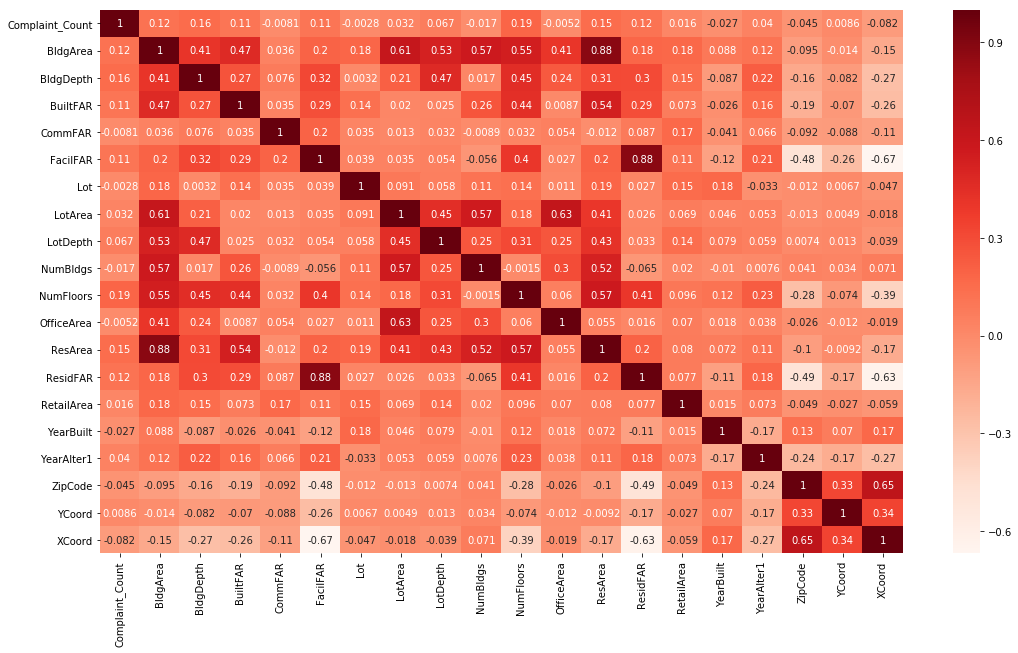

In [87]:
# using Pearson correlation
plt.figure(figsize=(18,10))
cor = df_merged.corr()
sns.heatmap(cor, annot = True, cmap=plt.cm.Reds)
plt.show()

## We'll select highly correlated features (positive or negative). Threshold is set to be 0.14 based on the figure above

In [88]:
#Correlation with output variable
cor_target = abs(cor["Complaint_Count"])
relevant_features = cor_target[abs(cor_target)>=0.14]
relevant_features

Complaint_Count    1.000000
BldgDepth          0.155332
NumFloors          0.187927
ResArea            0.147659
Name: Complaint_Count, dtype: float64

## <font color='red'> We can conclude that features: 'BldgDepth', 'NumFloors', and 'ResArea' are correlated with the number of complaints which answers our intial question. </font>

## We'll also investigate inter-feature correlation

In [89]:
# Investigate ineter-feature correlation
df_merged[['BldgDepth','NumFloors','ResArea']].corr()

,BldgDepth,NumFloors,ResArea
BldgDepth,1.000000,0.452952,0.314170
NumFloors,0.452952,1.000000,0.570169
ResArea,0.314170,0.570169,1.000000


## We will validate our findings using two methods below: Random Forrest and XGBoost algorithm

# <font color='red'> Random Forrest method for feature selection </font>

In [90]:
X = df_merged.drop(['Address','Complaint_Count'], axis=1)
y = df_merged['Complaint_Count']
names = list(X.columns)

scaler = RobustScaler()

# Split the data into 40% test and 60% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [91]:
print(X_train.shape)
print(X_test.shape)

(8001, 19)
(5335, 19)


In [92]:
# Create a RF Classifier and a pipeline
RFcls = RandomForestClassifier(random_state=0, n_jobs=2)
RFPipe = Pipeline(steps=[('scaler', scaler), ('classification', RFcls)])

# Train model
RFPipe.fit(X_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('classification', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min...estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [93]:
model = RFPipe.steps[1][1]

In [94]:
# list of x locations for plotting
feature_importances = pd.DataFrame(model.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
YCoord,0.104425
ResArea,0.103068
XCoord,0.102362
Lot,0.098181
BldgArea,0.084650
LotArea,0.083526
BldgDepth,0.076030
YearBuilt,0.072296
LotDepth,0.060963
ZipCode,0.046900


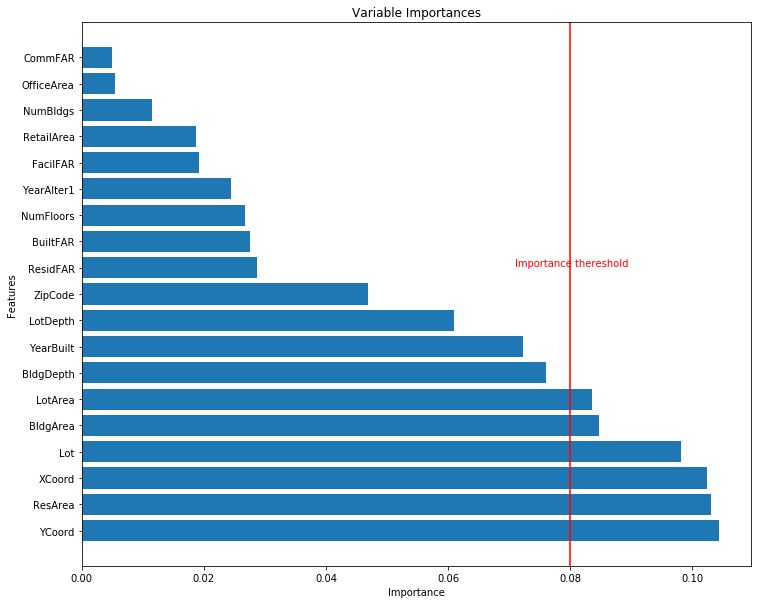

In [95]:
# Make a bar chart
plt.figure(figsize=(12,10))
plt.barh(feature_importances.index,feature_importances['importance'])

# Axis labels and title
plt.ylabel('Features'); plt.xlabel('Importance'); plt.title('Variable Importances');

plt.axvline(x = 0.080,color='red')
# Annotate Text
plt.annotate('Importance thereshold', # text to display
             xy=(0.071, 'ResidFAR'),                    # start the text at at point
             color='red',
             rotation=0,                  
             va='bottom',                    # want the text to be vertically 'bottom' aligned
             ha='left',                      # want the text to be horizontally 'left' algned.
            )
plt.show()

## <font color='maroon'> Based on importance threshold of 0.080, important features are: 'ResArea', 'BldgArea', 'XCoord', 'YCoord', 'Lot', 'BldgDepth' and 'LotArea' </font>

## We will create a selector object that will use the random forest classifier to identify features that have an importance of more than 0.080

In [96]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(model, threshold=0.08)

In [97]:
# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=0.08)

In [98]:
# Print the names of the most important features
important_feats = []
for feature_list_index in sfm.get_support(indices=True):
    print(names[feature_list_index])
    important_feats.append(names[feature_list_index])

BldgArea
Lot
LotArea
ResArea
YCoord
XCoord


In [99]:
len(important_feats)

6

## Create a subset with only the most important features obtained above

In [100]:
# Create a new random forest classifier for the most important features
# Create a RF Classifier and a pipeline
RF = RandomForestClassifier(random_state=0, n_jobs=2)
RFP = Pipeline(steps=[('scaler', scaler), ('classification', RF)])

In [101]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = X_train.loc[:,important_feats]
X_important_test = X_test.loc[:,important_feats]

X_important_train.shape

(8001, 6)

In [102]:
# Train model
RFP.fit(X_important_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('classification', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min...estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [103]:
# Train the new classifier on the new dataset containing the most important features
mod_rf = RFP.steps[1][1]

In [104]:
# Apply The Full Featured Classifier To The Test Data
y_pred = model.predict(X_test)

# View The Accuracy Of Our Full Feature (19 Features) Model
accuracy_allFeatures = accuracy_score(y_test, y_pred)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

rmse_allFeatures = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 19.72127460168697
Mean Squared Error: 15152.061293345829
Root Mean Squared Error: 123.09370939794539


In [105]:
# Apply Selected Important Features classifier
y_important_pred = mod_rf.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (10 Features) Model
accuracy_importantFeatures = accuracy_score(y_test, y_important_pred)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_important_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_important_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_important_pred)))  

rmse_importantFeatures = np.sqrt(metrics.mean_squared_error(y_test, y_important_pred))

Mean Absolute Error: 20.380693533270854
Mean Squared Error: 15231.72427366448
Root Mean Squared Error: 123.4168719165434


In [106]:
print('accuracy_allFeatures:', accuracy_allFeatures)
print('rmse_allFeatures:', rmse_allFeatures)
print('accuracy_importantFeatures:', accuracy_importantFeatures)
print('rmse_importantFeatures:', rmse_importantFeatures)

accuracy_allFeatures: 0.1246485473289597
rmse_allFeatures: 123.09370939794539
accuracy_importantFeatures: 0.27441424554826616
rmse_importantFeatures: 123.4168719165434


## It's shown that the model accuracy for full feature model and selected important features through RF approach are very close.

# XGBoost Algorithm to select important features

In [107]:
regXGB = XGBRegressor(observation = 'multi:softmax')
XGB_Pipe = Pipeline(steps=[('scaler', scaler), ('regression', regXGB)])

In [108]:
XGB_Pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('regression', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_... reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))])

In [109]:
modelXGB = XGB_Pipe.steps[1][1]
modelXGB

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear',
       observation='multi:softmax', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [110]:
total_importanceXGB = sum(modelXGB.feature_importances_)
col_names = X_train.columns.tolist()
feat_importance = modelXGB.feature_importances_

most_imp_ml_features = pd.DataFrame()
most_imp_ml_features['name'] = col_names
most_imp_ml_features['importance'] = feat_importance
most_imp_ml_features['percentage_importance'] = most_imp_ml_features['importance'].apply(lambda x: 1.0 * x / total_importanceXGB)


In [111]:
most_imp_ml_features = most_imp_ml_features.sort_values(by='importance',ascending=False)
most_imp_ml_features[['name','percentage_importance']].head(7)

,name,percentage_importance
11,ResArea,0.261765
0,BldgArea,0.094118
17,YCoord,0.082353
6,LotArea,0.076471
1,BldgDepth,0.064706
14,YearBuilt,0.063235
18,XCoord,0.057353


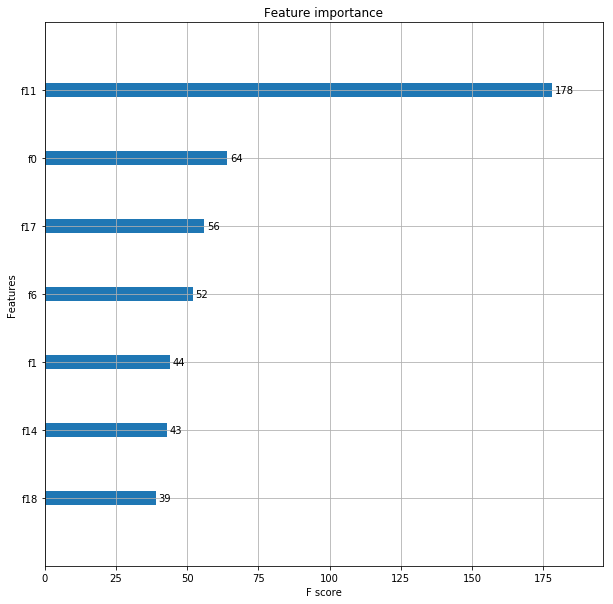

In [112]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(modelXGB, max_num_features=7, ax=ax)

## <font color='maroon'> Based on importance plot above, top 5 most important features are: 'ResArea', 'BldgArea', 'YCoord', 'LotArea', 'BldgDepth', 'YearBuilt' and 'XCoord'. </font>

# Concluding Remarks - Some of the building characteristics like Age of the Building (or YearBuilt), Residential Area, BuildingArea and X,Y Coordinates seems to have some relationship with Number of Heating Complaints as verified by two different algorithms.